In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import random
import shutil, sys
import pandas as pd

plt.ion()

In [46]:
#data augmentation apenas para o treinamento
#normalization para a validaa

data_transforms = {'train': transforms.Compose(
                    [transforms.RandomResizedCrop(224),
                    transforms.RandomRotation(degrees=(-10, 10)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ]),
                    'val': transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
                  }

In [47]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/dataset_original/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)
print("pneumonia : ", len_normal)
print("covid : ", len_pneumonia)


Files per classes
----------------------------------------
normal :  1341
pneumonia :  1345
covid :  505


In [16]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

#def split_dataset():
#path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
root = data_dir
normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

normal_xray = get_dataset(normal_dir, 'normal')
pneumonia_xray = get_dataset(pneumonia_dir, 'pneumonia')

#print(len(normal_xray), normal_xray[0:5])
#print(len(pneumonia_xray), pneumonia_xray[0:5])

# Load Covid-19 Dataset
# metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/metadata.csv'
# srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19_v2/covid-chestxray-dataset/images/'
# df=pd.read_csv(metadata_path)
# covid_patients=df['finding']=='COVID-19'
# PA=df['view']=='PA'
# PA_covid=df[covid_patients & PA]
covid_xray = get_dataset(covid_dir, 'covid')
#print(len(covid_xray), covid_xray[0:5])

random.shuffle(normal_xray)
random.shuffle(pneumonia_xray)
random.shuffle(covid_xray)

# gerando dados balanceados e randomizados
print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray)) -1
dataset = normal_xray + pneumonia_xray + covid_xray
random.shuffle(dataset)

#print(len(dataset), dataset[0:5])

# carregando os dados para um df pandas
df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
#print(df)

X = df['X']
y = df['y']

print (X)
X.shape
print('----------')
print (y)
y.shape

classes= y.unique()
print("Classes: {}".format(classes))

# Split em train, val, e test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #pega % do treino e separa para teste/
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #pega % do treino e separa para teste

print("-----"*10)
print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
print("-----"*10)
print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

#cria uma nova pasta com as duas bases de dados agrupadas
for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
  for _X, _y in zip(dinputs, doutputs):
    path = root+dtype+'/'+_y
    os.makedirs(path, exist_ok=True)
    print(_X, path)
    shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


min_size = 504
446     /home/jimi/dissertacao/covid19/datasets/datase...
564     /home/jimi/dissertacao/covid19/datasets/datase...
805     /home/jimi/dissertacao/covid19/datasets/datase...
1796    /home/jimi/dissertacao/covid19/datasets/datase...
499     /home/jimi/dissertacao/covid19/datasets/datase...
                              ...                        
2460    /home/jimi/dissertacao/covid19/datasets/datase...
1178    /home/jimi/dissertacao/covid19/datasets/datase...
369     /home/jimi/dissertacao/covid19/datasets/datase...
2151    /home/jimi/dissertacao/covid19/datasets/datase...
3076    /home/jimi/dissertacao/covid19/datasets/datase...
Name: X, Length: 3191, dtype: object
----------
446        normal
564        normal
805     pneumonia
1796       normal
499         covid
          ...    
2460       normal
1178    pneumonia
369     pneumonia
2151       normal
3076       normal
Name: y, Length: 3191, dtype: object
Classes: ['normal' 'pneumonia' 'covid']
------------------------

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (786).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (358).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (437).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (43).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (693).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (569).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/N

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (442).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (992).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (401).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1202).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (279).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1241).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/norma

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1285).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (261).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (849).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (44).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (548).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (282).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/dat

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (529).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/361.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (815).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (829).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (168).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (482).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (924).p

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (151).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1297).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1081).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (943).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1152).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (300).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pne

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1016).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/121.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/475.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (938).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (149).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (550).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (4

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (563).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (888).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (706).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (651).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1042).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1193).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/d

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1052).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (583).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (978).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (264).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (851).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/139.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (2

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1173).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (514).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (585).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (113).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/105.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/104.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORM

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/201.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1222).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/55.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1162).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (405).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/21.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (302).png /home/jimi/dissert

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (640).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (51).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (123).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (677).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (527).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/114.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/nor

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (678).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (833).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (274).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/503.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1084).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (294).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pn

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1097).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (20).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/274.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (706).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/53.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (464).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (80).png /home/jimi

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (604).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (208).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (222).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (262).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1178).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/433.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (657).png /home/ji

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (547).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/85.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (726).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (16).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1061).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (848).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/datase

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (88).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (474).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (758).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (138).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/59.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1084).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (931).png /home/jimi/di

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (698).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (142).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1299).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (806).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (167).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1108).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/h

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (155).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/322.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (930).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (393).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1193).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (202).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/data

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (873).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (569).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (548).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (852).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (910).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (834).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/disserta

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1338).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (551).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (582).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (767).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/150.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (334).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/data

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (985).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/335.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (696).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (287).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (918).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (179).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/datas

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (18).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (203).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/94.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/155.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (11).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (78).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1122).

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (185).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (645).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1326).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (662).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1036).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/180.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dat

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (318).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1128).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (612).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (213).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (499).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1141).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/norma

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (106).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/460.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/348.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (918).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1027).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1120).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (792).png /ho

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (491).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (229).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (846).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (958).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1323).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (542).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/da

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (679).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (227).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (692).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1028).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (273).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (690).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/da

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1013).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/241.png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1341).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1236).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (693).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1113).png /home/jimi/dissertacao/covid19/datasets/dataset_original/train/pneumonia
/home/jimi/dissertacao/covid19/datasets/d

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1335).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/151.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1302).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (399).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/129.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (927).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/270.jpeg /home/ji

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/273.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (700).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (399).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (375).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (850).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/54.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1067).png /h

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (476).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (492).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (691).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (124).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1334).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1253).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dis

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (601).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (70).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (60).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/192.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/426.png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1242).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1096).png /

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (604).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1050).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1303).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (549).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (594).png /home/jimi/dissertacao/covid19/datasets/dataset_original/val/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (270).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/203.jpeg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (959).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/6.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (425).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (14).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (389).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (608).png /home/jimi/disse

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (647).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1030).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (234).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/399.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (341).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/236.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1006).p

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (715).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1227).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (241).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (274).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/340.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (346).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1143).png /home/jimi/disse

/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (394).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/245.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1222).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (830).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (596).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (960).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_or

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/330.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1204).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (310).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/130.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/14.jpg /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (494).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (532).png /home/jimi/dissertacao/covid19/datasets/

/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/504.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1136).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (712).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1029).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (634).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/covid/452.png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/covid
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (629).png /home/jimi/dissertacao/c

/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1272).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1168).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (790).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/normal/NORMAL (1275).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/normal
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1231).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/datasets/dataset_original/pneumonia/Viral Pneumonia (1292).png /home/jimi/dissertacao/covid19/datasets/dataset_original/test/pneumonia
/home/jimi/dissertacao/covid19/data

In [49]:
def imshow(inp, title=None):
    """Imshow for tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pausa um pouco para que os gráficos sejam atualizados

In [50]:
#pega o batch de treinamento
inputs, classes = next(iter(dataloaders['train']))

In [51]:
#grid from batch
out = torchvision.utils.make_grid(inputs)

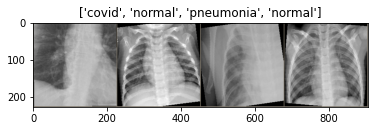

In [52]:
imshow(out, title=[class_names[x] for x in classes])

In [53]:
#traing
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range (num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-'*20)
        
        #cada epoca tem uma fase de treino e validação
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #seta o moledo para treinar
            else:
                model.eval() #seta para validação
                
            running_loss = 0.0
            running_corrects = 0
            
            # Itera sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero gradientes
                optimizer.zero_grad()
                
                #forward
                #rastrea o historico se apenas no treino
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    #backward + optimizer only se estiver no treino
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        
                #statistc
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #copia para o modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    #carrega o modelo com os melhores pesos
    model.load_state_dict(best_model_wts)
    
    return model

In [54]:
# Função genérica para mostrar as predições das imagens
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

In [42]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(512, 3),
                              nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
--------------------
train Loss: 0.9460 Acc: 0.6067
val Loss: 0.7957 Acc: 0.7672

Epoch 1/49
--------------------
train Loss: 0.8976 Acc: 0.6497
val Loss: 0.7787 Acc: 0.7691

Epoch 2/49
--------------------
train Loss: 0.8836 Acc: 0.6599
val Loss: 0.7776 Acc: 0.7703

Epoch 3/49
--------------------
train Loss: 0.8716 Acc: 0.6736
val Loss: 0.7975 Acc: 0.7492

Epoch 4/49
--------------------
train Loss: 0.8821 Acc: 0.6602
val Loss: 0.7892 Acc: 0.7492

Epoch 5/49
--------------------
train Loss: 0.8693 Acc: 0.6748
val Loss: 0.7172 Acc: 0.8343

Epoch 6/49
--------------------
train Loss: 0.8286 Acc: 0.7146
val Loss: 0.6863 Acc: 0.8622

Epoch 7/49
--------------------
train Loss: 0.7999 Acc: 0.7583
val Loss: 0.6661 Acc: 0.8845

Epoch 8/49
--------------------
train Loss: 0.7973 Acc: 0.7545
val Loss: 0.6711 Acc: 0.8883

Epoch 9/49
--------------------
train Loss: 0.7943 Acc: 0.7611
val Loss: 0.6768 Acc: 0.8759

Epoch 10/49
--------------------
train Loss: 0.7904 Acc: 0.7650
val Lo

In [60]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.2),
                                      nn.Linear(512, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
--------------------
train Loss: 0.9745 Acc: 0.6338
val Loss: 0.4303 Acc: 0.8485

Epoch 1/49
--------------------
train Loss: 0.7182 Acc: 0.7188


In [ ]:
model_conv = torchvision.models.densenet201(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier.in_features = (nn.Linear(num_ftrs, 512),
                                      nn.ReLU(),
                                      nn.Dropout(0.2),
                                      nn.Linear(512, 3),
                                      nn.Softmax(dim=1))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=50)